In [50]:
import pandas as pd
import numpy as np
import joblib
import shap
from shap import Explanation

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading the cleaned investor dataset
df = pd.read_csv("investor_profiles_cleaned.csv")

# Splitting features and target
y = df["risk_profile"]
X = df.drop(columns=["risk_profile"])

# Load the trained Random Forest pipeline
rf_pipeline = joblib.load("rf_risk_classifier.joblib")

rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['No '
                                                                              'experience',
                                                                              'Basic',
                                                                              'Advanced'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Can '
                                                                              'accept '
                                                                              'large '
                                                                              'swings',
                                                                              'Can '
                                                                              'accept '
                                                                              'small '
                                                                              'losses',
                                                                              'Very '
                                                                              'uncomfortable '
                                                                              'with '
                                                                              'losses'],
                                                                             ['Avoid '
                                                                              'risk',
                                                                              'Comfortable '
                                                                              'with '
                                                                              'some '
                                                                              'risk',
                                                                              'Comfortable '
                                                                              'with '
                                                                              'high '
                                                                              'risk']]),
                                                  ['investment_experience',
                                                   'financial_knowledge',
                                                   'loss_aversion',
                                                   'risk_preference']),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['income_band',
                                                   'primary_goal']),
                                                 ('numeric', 'passthrough',
                                                  ['age',
                                                   'investment_horizon_years'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [ ]:
# Using a sample of the data as background for SHAP
X_background = X.sample(500, random_state=42)  # 500 is fine for our size

# Transforming it using the same preprocessing as the model
preprocessor = rf_pipeline.named_steps["preprocessor"]
model = rf_pipeline.named_steps["model"]

X_background_transformed = preprocessor.transform(X_background)

# Getting feature names after encoding
feature_names = preprocessor.get_feature_names_out()
len(feature_names), feature_names[:10]

(12,
 array(['ordinal__investment_experience', 'ordinal__financial_knowledge',
        'ordinal__loss_aversion', 'ordinal__risk_preference',
        'nominal__income_band_High', 'nominal__income_band_Low',
        'nominal__income_band_Medium',
        'nominal__primary_goal_Aggressive growth',
        'nominal__primary_goal_Balanced growth',
        'nominal__primary_goal_Capital preservation'], dtype=object))

In [7]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_background_transformed)

In [9]:
rf_pipeline.classes_

array(['Aggressive', 'Conservative', 'Moderate'], dtype=object)

In [ ]:
classes = list(rf_pipeline.classes_)
moderate_idx = classes.index("Moderate")
print(moderate_idx)

#Taking SHAP values for the Moderate class (slice on last axis)
print("Full SHAP shape:", shap_values.shape)   # should be (500, 12, 3)
shap_mod = shap_values[:, :, moderate_idx]    # (500, 12)

#Checking shapes
print("X shape:", X_background_transformed.shape)
print("SHAP shape for Moderate:", shap_mod.shape)

2
Full SHAP shape: (500, 12, 3)
X shape: (500, 12)
SHAP shape for Moderate: (500, 12)


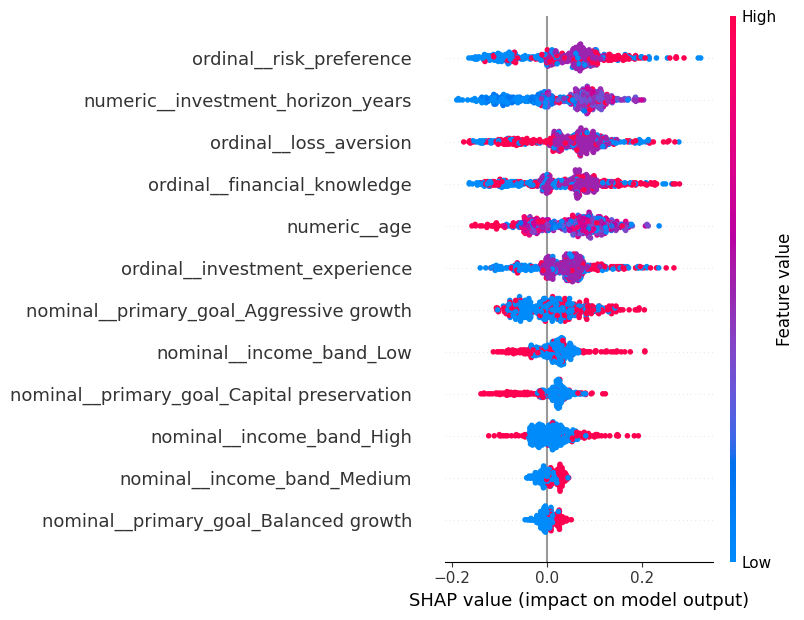

In [19]:
#Summary plot for Moderate class
shap.summary_plot(
    shap_mod,
    X_background_transformed,
    feature_names=feature_names,
    show=True
)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


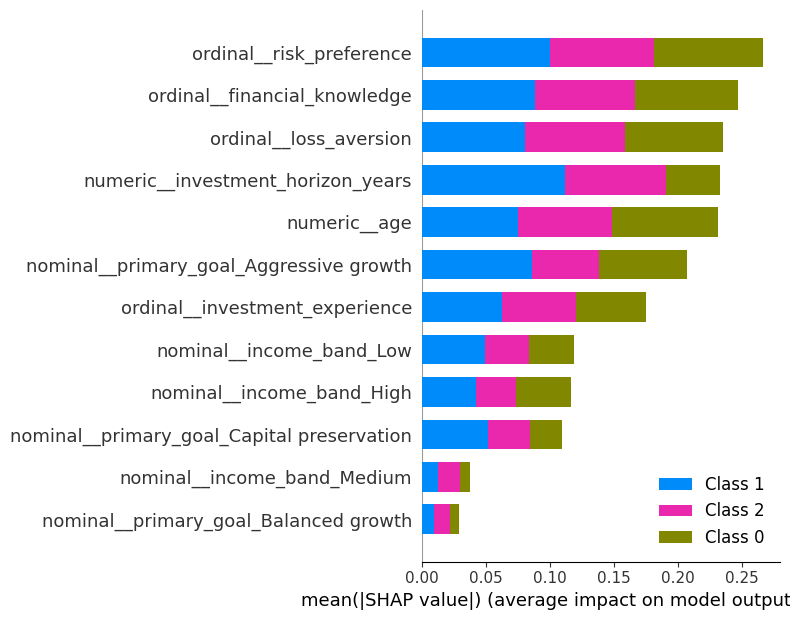

In [20]:
shap.summary_plot(
    shap_values,
    X_background_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

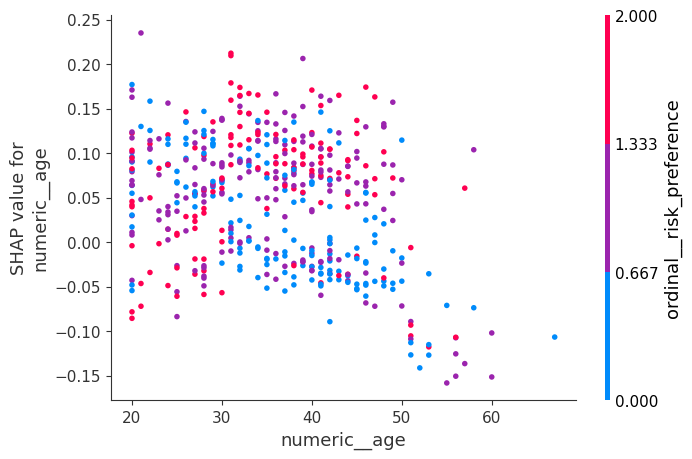

In [22]:
shap.dependence_plot(
    "numeric__age",          # or the index feature_names.index("numeric__age")
    shap_mod,                # 2D: (n_samples, n_features)
    X_background_transformed,
    feature_names=feature_names
)

In [24]:
X_shap = pd.DataFrame(X_background_transformed, columns=feature_names)

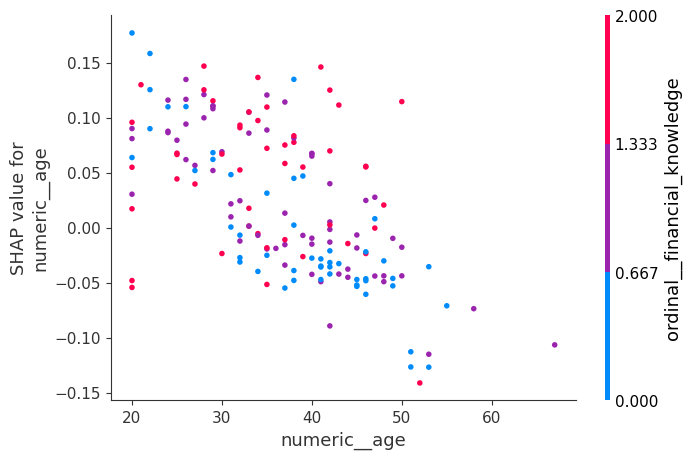

In [28]:
blue_idx = X_shap["ordinal__risk_preference"] == 0

shap.dependence_plot(
    "numeric__age",
    shap_mod[blue_idx],
    X_background_transformed[blue_idx],
    feature_names=feature_names
)

In [26]:
print(X_shap.columns.tolist())

['ordinal__investment_experience', 'ordinal__financial_knowledge', 'ordinal__loss_aversion', 'ordinal__risk_preference', 'nominal__income_band_High', 'nominal__income_band_Low', 'nominal__income_band_Medium', 'nominal__primary_goal_Aggressive growth', 'nominal__primary_goal_Balanced growth', 'nominal__primary_goal_Capital preservation', 'numeric__age', 'numeric__investment_horizon_years']


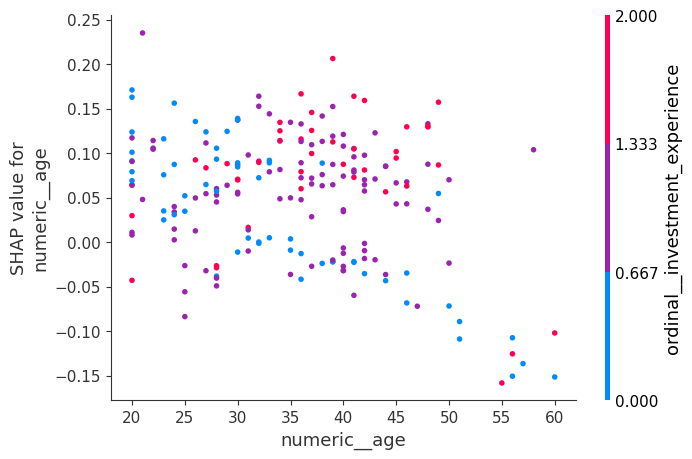

In [30]:
# PURPLE = medium
purple_idx = X_shap["ordinal__risk_preference"] == 1
shap.dependence_plot(
    "numeric__age",
    shap_mod[purple_idx],
    X_background_transformed[purple_idx],
    feature_names=feature_names
)

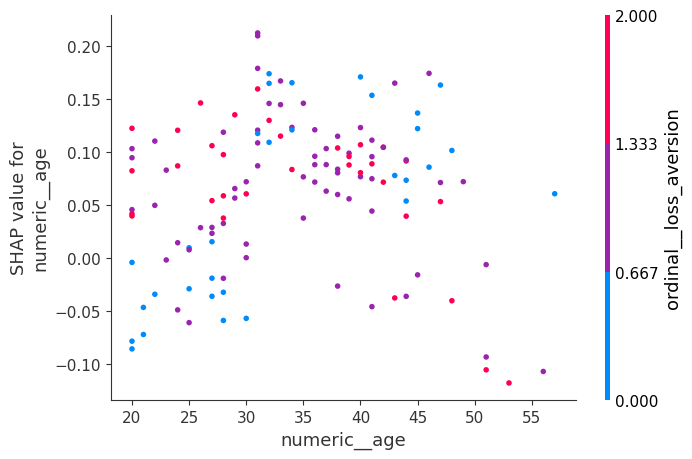

In [31]:
# RED = high
red_idx = X_shap["ordinal__risk_preference"] == 2
shap.dependence_plot(
    "numeric__age",
    shap_mod[red_idx],
    X_background_transformed[red_idx],
    feature_names=feature_names
)

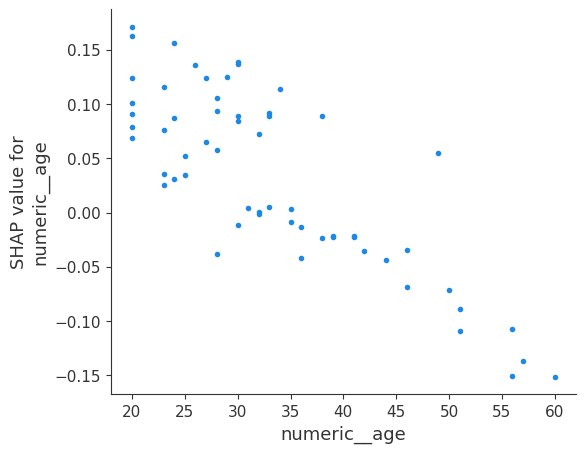

In [ ]:
# medium risk preference
purple_idx = X_shap["ordinal__risk_preference"] == 1

# within that group: low investment experience (blue = 0)
low_exp_idx = X_shap["ordinal__investment_experience"] == 0

# combining both conditions
purple_lowexp_idx = purple_idx & low_exp_idx

shap.dependence_plot(
    "numeric__age",
    shap_mod[purple_lowexp_idx],
    X_background_transformed[purple_lowexp_idx],
    feature_names=feature_names,
    interaction_index=None   # optional: removes colour scale so all dots are same colour
)

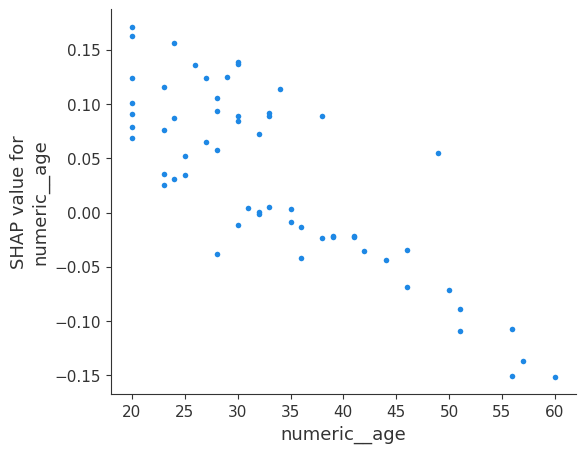

In [35]:
purple_idx = X_shap["ordinal__risk_preference"] == 1
low_exp_idx = X_shap["ordinal__investment_experience"] == 0

subset_low = purple_idx & low_exp_idx

shap.dependence_plot(
    "numeric__age",
    shap_mod[subset_low],
    X_background_transformed[subset_low],
    feature_names=feature_names,
    interaction_index=None
)

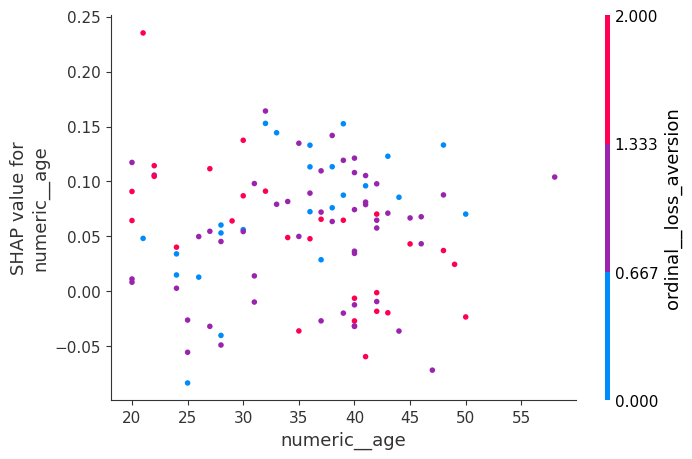

In [36]:
med_exp_idx = X_shap["ordinal__investment_experience"] == 1

subset_med = purple_idx & med_exp_idx

shap.dependence_plot(
    "numeric__age",
    shap_mod[subset_med],
    X_background_transformed[subset_med],
    feature_names=feature_names
)

In [ ]:
# choosing a row index between 0 and len(X_background_transformed)-1
sample_index = 10   # you can change this later

In [43]:
shap_mod[sample_index]   # shape (12,)

array([ 0.073339  ,  0.17713055, -0.021713  , -0.00088669, -0.00601699,
        0.03935772,  0.0280258 ,  0.13789412,  0.01786013,  0.0383329 ,
        0.09756409, -0.0390881 ])

In [44]:
X_background_transformed[sample_index]     # shape (12,)

array([ 1.,  2.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  0., 34.,  5.])

In [66]:
sample_shap = shap_values[sample_index, :, moderate_idx]
sample_features = X_background_transformed[sample_index]

expl = Explanation(
    values=sample_shap,
    base_values=shap_explainer.expected_value[moderate_idx],
    data=sample_features,
    feature_names=feature_names
)

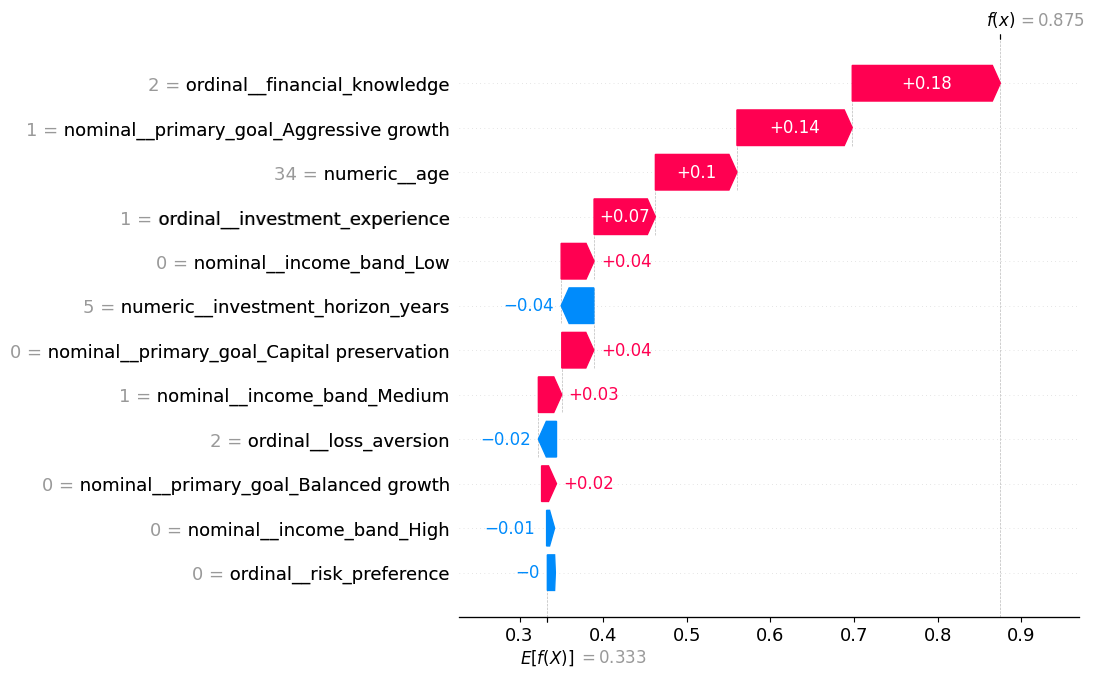

In [69]:
shap.plots.waterfall(expl, max_display=15)

In [74]:
aggressive_idx = list(rf_pipeline.classes_).index("Aggressive")  # should be 0

In [ ]:
# model predictions on the background sample (before preprocessing we used X_background)
y_pred_background = rf_pipeline.predict(X_background)

# indices where the model predicts 'Aggressive'
aggressive_indices = np.where(y_pred_background == "Aggressive")[0]

# picking an example (e.g. a random aggressive investor)
sample_index_aggr = np.random.choice(aggressive_indices)
sample_index_aggr

np.int64(171)

In [76]:
# 1) SHAP values for this row and the Aggressive class
sample_shap_aggr = shap_values[sample_index_aggr, :, aggressive_idx]

# 2) Feature values (already transformed)
sample_features_aggr = X_background_transformed[sample_index_aggr]

# 3) Build Explanation object
expl_aggr = Explanation(
    values=sample_shap_aggr,
    base_values=shap_explainer.expected_value[aggressive_idx],
    data=sample_features_aggr,
    feature_names=feature_names
)

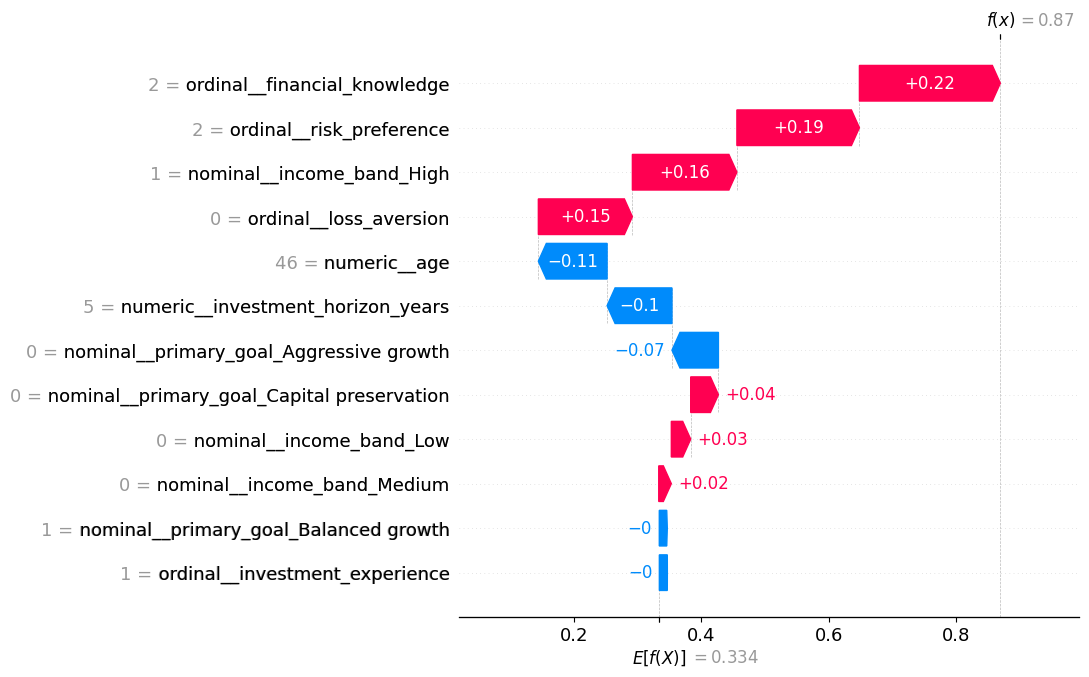

In [77]:
plt.figure(figsize=(10, 6))
shap.plots.waterfall(expl_aggr, max_display=15)